## - Introduction to Machine Learning and Data Mining - <br> <br> <i> Project 2: Supervised Machine Learning </i>

### **_by Sebastian Sbirna_**

***

In this report, we will evaluate the performance and characteristics of various types of supervised learning models upon our chosen Heart Disease dataset. For more information upon the actual data dictionary and a description of the properties of our observations and attributes, please refer to our former project [1]. 

### I. Regression Models

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, show, clim, semilogx, loglog, title, subplot, grid

import sklearn.linear_model as lm
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn import model_selection, tree
from scipy import stats
import torch

from toolbox_02450 import feature_selector_lr, bmplot, rlr_validate, train_neural_net

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Regression, part A

Our dataset was collected for classification purposes, having 14 attributes: 5 numerical and 9 categorical. Out of the 14 attributes, there exists one ‘target’ variable which should be predicted in a classification setting. Otherwise, there are no variables which were collected specifically for a regression purpose within this dataset, therefore model results within this section may be prone to more errors.

Still, we will use one of the five numerical (_of ratio type_) attributes as our criterion (_i.e. dependent_) variable for a regression analysis, where the other 13 attributes (_which increase to 20 attributes after a one-out-of-K encoding_) will all act as predictor (_i.e. independent_) variables. Now, we must decide which variable is best suited to serve as criterion.

However, our dataset has one important peculiarity which makes regression extremely difficult: most of our attributes are either uncorrelated or weakly correlated with each other, resulting in very little predictive power being stored in our dataset for any variable. 

#### Loading the dataset and performing data wrangling:

In [4]:
df = pd.read_csv('heart.csv')

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
df.drop(index = (df[df.ca == 4]).index, inplace = True)

df.drop(index = (df[df.thal == 0]).index, inplace = True)
df.loc[df.thal == 1, 'thal'] = 6
df.loc[df.thal == 3, 'thal'] = 7
df.loc[df.thal == 2, 'thal'] = 3

df.loc[df.cp == 0, 'cp'] = 4
df.loc[df.cp == 3, 'cp'] = 7
df.loc[df.cp == 2, 'cp'] = 3
df.loc[df.cp == 1, 'cp'] = 2
df.loc[df.cp == 7, 'cp'] = 1

df.loc[df.slope == 2, 'slope'] = 3
df.loc[df.slope == 1, 'slope'] = 2
df.loc[df.slope == 0, 'slope'] = 1

In [7]:
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [8]:
df['sex_male'] = df.sex
df.drop(columns = 'sex', inplace = True)

df = pd.get_dummies(data = df, columns = ['cp'], drop_first=True)
df.rename({'cp_2': 'cp_atypical', 'cp_3' : 'cp_non_anginal', 'cp_4': 'cp_asymptomatic'}, axis = 'columns', inplace = True)

df['fbs_true'] = df.fbs
df.drop(columns = 'fbs', inplace = True)

df = pd.get_dummies(data = df, columns = ['restecg'], drop_first=True)
df.rename({'restecg_1': 'restecg_st_t', 'restecg_2' : 'restecg_hypertrophy'}, axis = 'columns', inplace = True)

df['exang_yes'] = df.exang
df.drop(columns = 'exang', inplace = True)

df = pd.get_dummies(data = df, columns = ['slope'], drop_first=True)
df.rename({'slope_2': 'slope_flat', 'slope_3' : 'slope_downsloping'}, axis = 'columns', inplace = True)

df = pd.get_dummies(data = df, columns = ['ca'], drop_first=True)

df = pd.get_dummies(data = df, columns = ['thal'], drop_first=True)
df.rename({'thal_6': 'thal_fixed', 'thal_7' : 'thal_reversible'}, axis = 'columns', inplace = True)

df['target_true'] = df.target
df.drop(columns = 'target', inplace = True)
df.rename({'target_true': 'target'}, axis = 'columns', inplace = True)

In [9]:
df.head()

,age,trestbps,chol,thalach,oldpeak,sex_male,cp_atypical,cp_non_anginal,cp_asymptomatic,fbs_true,...,restecg_hypertrophy,exang_yes,slope_flat,slope_downsloping,ca_1,ca_2,ca_3,thal_fixed,thal_reversible,target
0,63,145,233,150,2.3,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,37,130,250,187,3.5,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,41,130,204,172,1.4,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,56,120,236,178,0.8,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,57,120,354,163,0.6,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1


We need a way to quantifiably analyze and select one between the five attributes which is best suitable for regression analysis. A simple OLS linear regression model has been chosen as testing methodology, where we select one variable to be predicted according to all our other variables in the dataset, and measuring the values of the MSE residuals when plotting the estimated data points against the true line of fitting (of the criterion variable). The results are easily noticeable from the following plots comparing the linear model’s prediction residuals:

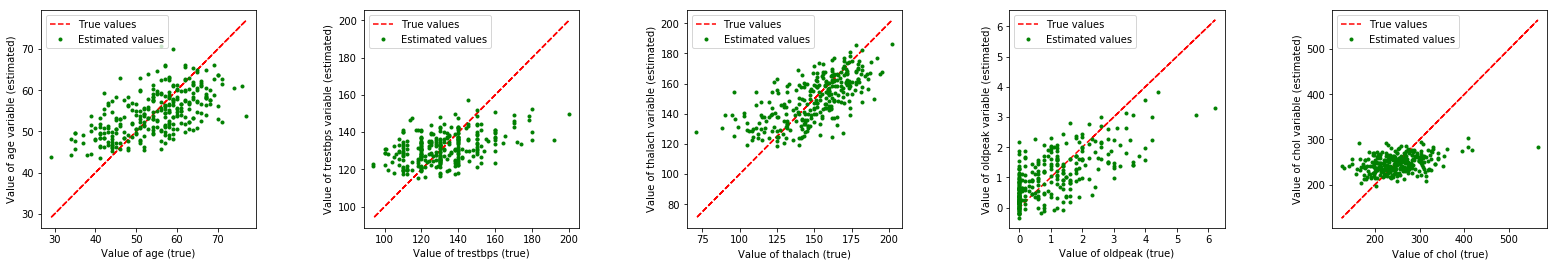

In [10]:
criterion_variables = ['age', 'trestbps', 'thalach', 'oldpeak', 'chol']

# Display plot
plt.figure(figsize=(27,4))
plt.subplots_adjust(wspace = 0.5)

for i in range(5):
    attr_col = list(df.columns).index(criterion_variables[i])
    cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

    X = raw_data[:, cols]
    y = raw_data[:, attr_col] # the 'oldpeak' column
    attributeNames = list(df.columns[cols])

    N, M = X.shape
    
    X = stats.zscore(X);

    # Fit ordinary least squares regression model    
    model = lm.LinearRegression()
    model.fit(X,y)

    # Predict thalach
    y_est = model.predict(X)
    residual = y_est-y
    
    plt.subplot(1, 5, i+1)
    plt.plot(y, y, '--r')
    plt.plot(y, y_est, '.g')
    plt.xlabel('Value of {0} (true)'.format(criterion_variables[i])); ylabel('Value of {0} variable (estimated)'.format(criterion_variables[i]))
    plt.legend(['True values', 'Estimated values'], loc = 2);

As noticed from fig. 2 above, our dataset does not have high predictive power for variables ‘oldpeak’ and ‘trestbps’, while the prediction of ‘chol’ is both weak and influenced by outliers. Unfortunately, upon having checked our outliers (which can be found in ‘chol’, ‘oldpeak’ and ‘trestbps’; see [1]), it was clear that these outliers needed to be kept, as they are not misreadings or errors within the data but were reflecting actual human patients’ infrequent body conditions, therefore removing such outliers would bias our dataset and our results. Since the data has widely different scales of measurement, the predictor data matrix (‘X’) has been standardized before performing both the test above and also for further tests.

Both ‘age’ and ‘thalach’ estimations seem to align well with the line of true fit of the criterion, however ‘thalach’ has lower average MSE residuals overall. Therefore, we have now chosen with confidence ‘thalach’ as our criterion (dependent) variable to be estimated using all other dataset attributes.

#### Regression, Part A - 1

In the following sections, we will examine and evaluate a regression problem involving predicting the maximum heart rate achieved by a person (variable ‘thalach’) using some or all of the other features present within the dataset. Since our original dataset includes 14 categorical variables, when performing regression, it is necessary to encode them using the one-out-of-K method, so as for the linear regression model to not understand the numerical category mappings as continuous values (thus potentially wrongly establishing that e.g. category 2 is “less” than category 3). After this feature transformation, from a total of 16 original variables, we end up with 21 variables (including the criterion variable). We must mention that, for each categorical encoding with N categories, we have only saved N-1 variables in our dataset, since the final categorical possibility will be automatically achieved when all remaining categorically-encoded attributes will have the value ‘0’.

In a linear regression problem, we are predicting our dependent variable through a linear combination of a coupling between the values of the independent variables with some set of weights representing the magnitude and direction of influence upon the variable to be predicted. The linear model is trained/fitted to a set of pre-defined input data (_i.e. training data_), from which the linear regression model estimated the values of its weights for each independent variable, so as to minimize the mean residual square error. When we try to estimate the criterion variable based on new data, the linear model will use its learned weight parameters for each individual predictor variable and will output an estimate of the predictor.

We are interested in discovering whether we can improve this model by reaching the same prediction power using fewer attributes. For this purpose, we perform a forward selection test with cross-validation across 5 outer folds and 10 inner folds, where we train a model starting with no features and gradually select and add, one-by-one, the features which minimize the squared error in the inner cross-validation loop, until the error cannot be minimized by adding any further predictors. Finally, we compute the R2 value of both the full model without feature selection and the newly-fitted feature-selecting model upon a test set, in order to see what percentage of the variance within the dataset is explained by each model. The result of the forward-selection algorithm upon our dataset is shown in figure 3:

Linear regression without feature selection:

- Training error: 286.24891952284895
- Test error:     334.59323831880266
- R^2 train:     0.45470240763896447
- R^2 test:     0.3449764346545811

Linear regression with feature selection:

- Training error: 305.7664859398442
- Test error:     343.8193255970184
- R^2 train:     0.41752189358261504
- R^2 test:     0.32691478877814295


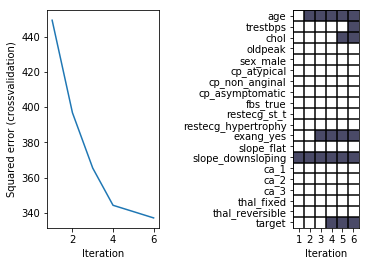

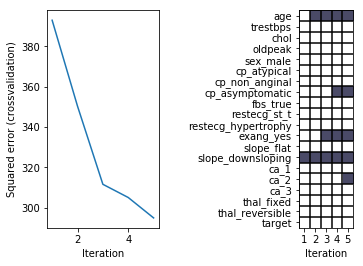

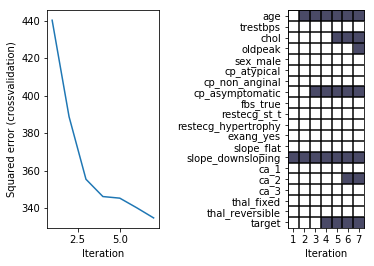

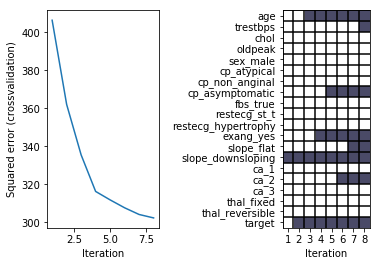

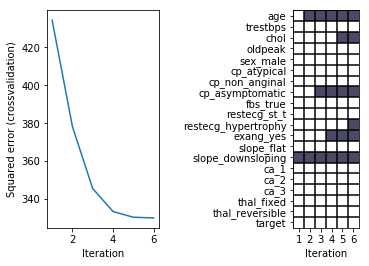

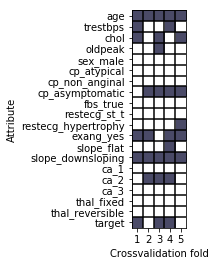

In [11]:
raw_data = df.get_values()
attr_col = list(df.columns).index('thalach')

cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col] # the 'thalach' column
attributeNames = list(df.columns[cols])

N, M = X.shape

# # # Additional nonlinear attributes

# age_index = attributeNames.index('age')
# trestbps_index = attributeNames.index('trestbps')
# thalach_index = attributeNames.index('thalach')
# oldpeak_index = attributeNames.index('oldpeak')
# chol_index = attributeNames.index('chol')

# X_age_trestbps = (X[:,age_index]*X[:,trestbps_index]).reshape(-1,1)
# # X_age_thalach = (X[:,age_index]*X[:,thalach_index]).reshape(-1,1)
# X_age_chol = (X[:,age_index]*X[:,chol_index]).reshape(-1,1)
# X_age_2 = np.power(X[:,age_index], 2).reshape(-1,1)
# X_oldpeak_2 = np.power(X[:,oldpeak_index], 2).reshape(-1,1)
# X = np.asarray(np.bmat('X, X_age_trestbps, X_age_chol, X_age_2', X_oldpeak_2))

X = stats.zscore(X);

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
for train_index, test_index in CV.split(X):
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all (i.e. without using any features)
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    textout = '';
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k]=1
    # .. alternatively you could use module sklearn.feature_selection
    
    if len(selected_features) is 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        figure(k)
        plt.subplots_adjust(wspace = 1.0)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,2,2)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        clim(-1.5,0)
        xlabel('Iteration')
    k+=1

# Display results
print('Linear regression without feature selection:\n')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print()
print('Linear regression with feature selection:\n')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))

figure(k)
subplot(1,3,2)
bmplot(attributeNames, range(1,Features.shape[1]+1), -Features)
clim(-1.5,0)
xlabel('Crossvalidation fold')
ylabel('Attribute');

From the forward selection algorithm, we can clearly see that our criterion ‘thalach’ is best described using the features: ‘age’, ‘slope_downsloping’ and ‘exang_yes’, while many other variables have been left out completely from our model, due to the low assistance in further reducing the MSE of the estimates. However, the $R_2$ metric results shows that, for predictions on a test set using the full model, ~34% of the variance is explained by the predictors (rather low for performing reliable regression), however when using the feature selected model, ~33% to ~35% of the variance is explained (depending on the extracted features). This suggests that feature selection has no optimization impact upon our regression models, and it may even increase the MSE error in some situations. This means that, even though the criterion is predicted, to a large extent by only a few numbers of attributes, the full model is definitely not overfitting on the data and even the terms having very low correlation will help slightly reduce the MSE. Re-running the test more times yielded similar results, therefore the full model will be used from further on.

Lastly here, another type of feature transformation could be the addition of interactions between terms or power series of the terms most highly-correlated with the criterion. Indeed, we have performed a test adding both interaction terms and squared terms of the most important predictor attributes, found from the forward selection step. Training a new model using all of our original parameters plus these feature transformations has yielded a decrease in generalization error of less than 1%, thereby we understand that, in our situation, such feature transformations should not be further included in the regression problem.

Since our attributes are all measured on widely different scales of values and since we will perform regularization in the next subpart, we will standardize all attributes accordingly, so that each column has µ = 0 and σ = 1.

#### Regression, Part A - 2

Since we would like to work with a linear regression model which gives out the lowest possible generalization error, we consider introducing a regularization parameter λ into the linear regression, which will take values between $10^{-5}$ and $10^{9}$. The role of λ, known as regularization strength, is to minimize the overall sum-of-squares error term and reduce the variance in the dataset by introducing a small amount of bias (_meaning that training error will slightly increase, however, generally, generalization error will decrease_).

In order to reliably estimate the generalization error for different values of λ, we have performed two-level cross-validation testing, with the outer layer having K1 = 10 folds and the inner fold being selected to K2 = 10 folds. The two-levels are useful when selecting the optimal value of λ for our model and data so as to minimize the generalization error, since we do not want to simply take an optimistic minimal value which occurred due to randomness. We estimate the generalization error by taking the mean test error given by each possible λ value within the 10 folds, and selecting the λ for which this error is minimum. 


Validation error for optimal lambda in k=1: 320.5017923102108
Optimal lambda selected in k=1: 100.0


Validation error for optimal lambda in k=2: 349.87491506960527
Optimal lambda selected in k=2: 100.0


Validation error for optimal lambda in k=3: 338.23257723338196
Optimal lambda selected in k=3: 100.0


Validation error for optimal lambda in k=4: 319.48093801621474
Optimal lambda selected in k=4: 100.0


Validation error for optimal lambda in k=5: 339.16103801687177
Optimal lambda selected in k=5: 100.0


Validation error for optimal lambda in k=6: 344.10437241287656
Optimal lambda selected in k=6: 100.0


Validation error for optimal lambda in k=7: 336.29257846497615
Optimal lambda selected in k=7: 100.0


Validation error for optimal lambda in k=8: 336.61683906908445
Optimal lambda selected in k=8: 100.0


Validation error for optimal lambda in k=9: 319.1613792655634
Optimal lambda selected in k=9: 100.0


Validation error for optimal lambda in k=10: 318.6730355767922
Optimal lam

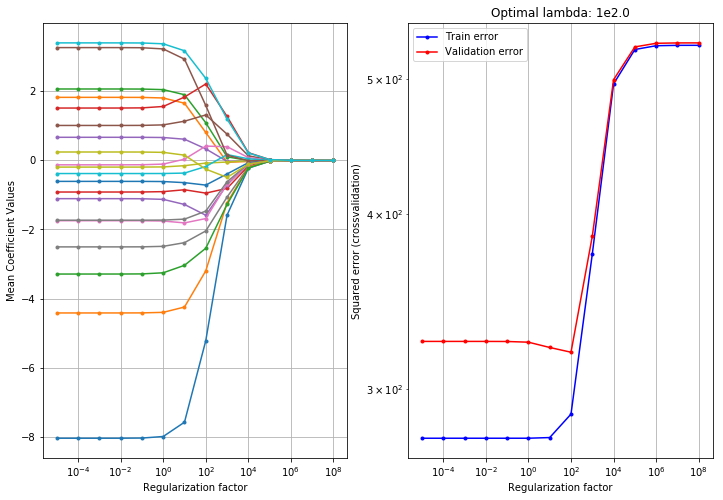

Linear regression without feature selection:
- Training error: 288.25370674686707
- Test error:     343.770379519363
- R^2 train:     0.4516131314578656
- R^2 test:     0.3219791951907874

Regularized linear regression:
- Training error: 314.4604224296826
- Test error:     339.8251786334996
- R^2 train:     0.40175629211219277
- R^2 test:     0.32976034341975075



Generalization error for different values of lambda:
               1e-05               345.33
              0.0001               345.33
               0.001               345.33
                0.01               345.32
                 0.1               345.26
                 1.0               344.68
                10.0               340.35
               100.0               332.21
              1000.0                390.2
             10000.0               498.94
            100000.0               525.55
           1000000.0               528.57
          10000000.0               528.88
         100000000.0             

In [123]:
raw_data = df.get_values()
attr_col = list(df.columns).index('thalach')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col]
attributeNames = list(df.columns[cols])
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)

# Values of lambda
lambdas = np.power(10.,range(-5,9))

# Initialize variables
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
val_error_lambdas = np.empty((K,len(lambdas)))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)
    val_error_lambdas[k] = test_err_vs_lambda
    
    print()
    print("Validation error for optimal lambda in k={0}: {1}".format(k+1, opt_val_err))
    print("Optimal lambda selected in k={0}: {1}".format(k+1, opt_lambda))
    print()
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]
    

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(12,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
#        legend(attributeNames[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error'])
        grid()

    k+=1

show()
# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))
print()
print()

print('Generalization error for different values of lambda:')
for i in range(len(lambdas)):
    print('{:>20} {:>20}'.format(float(lambdas[i]), str(np.round(val_error_lambdas.mean(axis = 0)[i],2))))

Figure 4 (right side) shows the trend of generalization error drop and subsequent increase for increasing λ, while fig. 4 (left side) illustrates the value of the linear model’s coefficients depending on λ, showing that, as λ increases, all weights (except the intercept) decrease and converge towards 0 (_since λ’s purpose is minimizing the weights in order to minimize variance with minimal bias introduction_).

Ideally, as seen from Figure 4, we will want to select λ as $10^2$ = 100, in order to minimize the mean squared errors in the linear regression model. Unfortunately, as expected due to our poor predictors in the dataset for a regression problem, when computing the overall generalization error using the two-level cross-validation, we find that, when using the full unregularized linear model, we get a testing error of **_343.7_** and _$R^2$_ of 32.2%, while using the regularized linear regression model only achieved a slight error reduction to **_339.8_** and _$R^2$_ increase to 32.9%, thus making clear that our models cannot easily be improved through internal attribute tweaking, but we would need to gather new data to find and add powerful predictors.

#### Regression, Part A - 3

In [43]:
raw_data = df.get_values()
attr_col = list(df.columns).index('thalach')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col]
attributeNames = list(df.columns[cols])
N, M = X.shape

X = stats.zscore(X)

ridgereg_model = Ridge(alpha = 100, fit_intercept = True).fit(X, y)
linreg_model = LinearRegression(fit_intercept = True).fit(X, y)
    
print('Weights for LinReg model with regularization:')
print('{:>20} {:>20}'.format('Intercept', str(np.round(ridgereg_model.intercept_,2))))
for m in range(M):
    print('{:>20} {:>20}'.format(attributeNames[m], str(np.round(ridgereg_model.coef_[m],2))))
    
print()
print()

print('Weights for LinReg model without regularization:')
print('{:>20} {:>20}'.format('Intercept', str(np.round(linreg_model.intercept_,2))))
for m in range(M):
    print('{:>20} {:>20}'.format(attributeNames[m], str(np.round(linreg_model.coef_[m],2))))

Weights for LinReg model with regularization:
           Intercept               149.56
                 age                -5.05
            trestbps                 1.08
                chol                 1.16
             oldpeak                -1.57
            sex_male                  0.3
         cp_atypical                 0.89
      cp_non_anginal                 0.33
     cp_asymptomatic                -2.46
            fbs_true                -0.04
        restecg_st_t                -0.58
 restecg_hypertrophy                -0.74
           exang_yes                -3.03
          slope_flat                -2.57
   slope_downsloping                 2.67
                ca_1                -1.59
                ca_2                 1.16
                ca_3                -1.29
          thal_fixed                -1.23
     thal_reversible                -0.03
              target                 2.31


Weights for LinReg model without regularization:
           Intercept 

Through the selection of λ as $10^2$ = 100 and fitting our linear model upon our whole dataset, we find that the regularized linear model has the equation:

$y ̌ = 149.5 - 5.05x_{age} + 1.08x_{trestbps} + 1.16x_{chol} - 1.57x_{oldpeak} + 0.3x_{sex-male} + 0.89x_{cp-atypical} + 0.33x_{cp-nonanginal} - 2.46x_{cp-asymptomatic} - 0.04x_{fbs-true} - 0.58x_{restecg-st-t} - 0.74x_{restecg-hypertrophy} - 3.03x_{exang-yes} - 2.57x_{slope-flat} + 2.67x_{slope-downsloping} - 1.59x_{ca-1} + 1.16x_{ca-2} - 1.29x_{ca-3} - 1.23x_{thal-fixed} - 0.03x_{thal-reversible} + 2.31x_{target}$

These results can be interpreted well, knowing that our data is standardized and our criterion variable is the maximum heartbeat rate achieved during hospital stay. The weights in the equation show that e.g. for an increase of 1 age unit, the maximum heartrate should go down 5.05 units; or that if a patient has heart disease ($x_{target} = 1$), we expect its maximum heartrate to be 2.31 units higher than of a patient without heart disease. All such findings seem relevant, as, with increasing of age, the human heart pumps blood slower; and angiographic heart disease results in high heart rate. The other parameters are also showing sensible results.

### Regression, part B

For our regression problem, we will compare three supervised modelling techniques, evaluate their general performance using two-level cross-validation and statistically determine whether the performance of different models is comparable or significantly different.

#### Regression, Part B - 1

In order to compute a generalization error estimate of the Mean Square Error residuals for each of our models, we will use a two-level cross-validation with $K_1$ = 10 outer and $K_2$ = 10 inner folds. The inner folds will be used to compute, for each model, a complexity-controlling parameter which minimizes the generalization error for that model, and the outer folds are used to test the model’s performance upon different segmented parts of our datasets (which, if they would be perfectly uncorrelated, they would function as completely separate datasets).

For the regularized linear regression, we are trying to find an optimal parameter of λ (the regularization strength) which minimizes the MSE and dataset variance while introducing a minimum of bias error. An intercept column is fitted to this linear model. The selected values for potential λ are powers of 10 within the range of $10^{-5}$ and $10^9$, to coincide with the range of λ selected for the previous exercise. For the Artificial Neural Network, we will train networks using one linear hidden layer and one output layer, with a **_tanh_** (hyperbolic tangent; non-linear) activation function in the hidden layer and, as for the complexity parameter, we have selected to tweak and cross-validate the number of hidden units within the single hidden layer, selecting from a range varying between **_1_** and **_5_** hidden units. The loss function for the ANN has been selected to be the MSELoss (Mean Squared Error loss), as we are dealing with a regression task at hand. If convergence is not able to be easily reached, we have set the maximum number of epochs (iterations) to 10000 epochs. The particular ANN models are each trained in a set of three replicate networks, which is necessary since NNs can become trapped in local minima due to the non-convex loss function (which is solved using gradient descent). Therefore, the same NN model must be trained multiple times, and the one which produces the minimum error (i.e. the lowest ‘local minimum’) will be considered as our trained model. Finally, for our baseline we have applied a linear regression model with only an intercept value corresponding to the mean of the criterion variable (**_y_**) on the training data.

#### Regression, Part B - 2, 3

Performing a statistical evaluation on the differences of means in generalization error of the three models, we will use the 95% credibility interval methods. If the computed interval contains the value 0.0 (as a difference of means), then we cannot be certain that our models are significantly different, otherwise, the one showing the lower error will be the better model.

Computing CV1 fold: 1/10..

Error rate - regularized lin-reg - CV1 fold 1/10: 260.39
Optimal lambda: 100.0
Error rate - Regression ANN - CV1 fold 1/10: 8996.68
Optimal number of hidden units: 5
Error rate - baseline lin-reg - CV1 fold 1/10: 465.37


Computing CV1 fold: 2/10..

Error rate - regularized lin-reg - CV1 fold 2/10: 269.79
Optimal lambda: 100.0
Error rate - Regression ANN - CV1 fold 2/10: 8831.74
Optimal number of hidden units: 5
Error rate - baseline lin-reg - CV1 fold 2/10: 527.01


Computing CV1 fold: 3/10..

Error rate - regularized lin-reg - CV1 fold 3/10: 467.4
Optimal lambda: 100.0
Error rate - Regression ANN - CV1 fold 3/10: 8957.57
Optimal number of hidden units: 5
Error rate - baseline lin-reg - CV1 fold 3/10: 810.31


Computing CV1 fold: 4/10..

Error rate - regularized lin-reg - CV1 fold 4/10: 367.6
Optimal lambda: 100.0
Error rate - Regression ANN - CV1 fold 4/10: 9412.92
Optimal number of hidden units: 5
Error rate - baseline lin-reg - CV1 fold 4/10: 676.31


Co

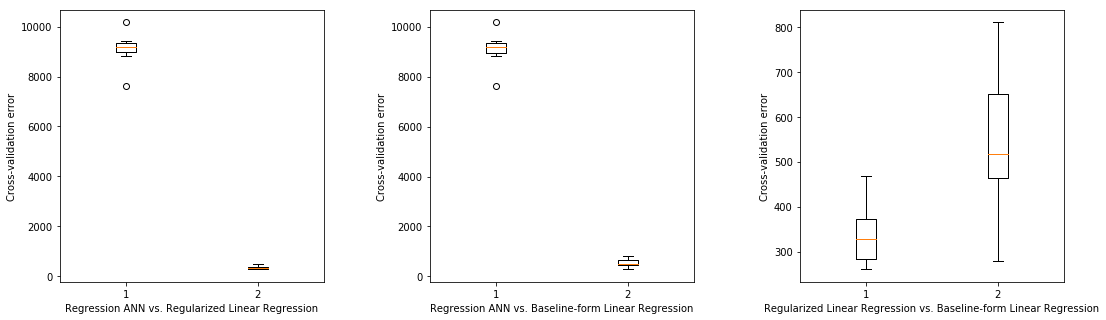

In [14]:
raw_data = df.get_values()
attr_col = list(df.columns).index('thalach')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col]
attributeNames = list(df.columns[cols])
N, M = X.shape

K1 = 10 # for model selection
K2 = 10 # for optimal parameter selection

# K-fold crossvalidation
CV1 = model_selection.KFold(n_splits=K1, shuffle=True)

X = stats.zscore(X)

# Initialize variable
linreg_test_error_k1 = np.zeros(K1)
ann_test_error_k1 = np.zeros(K1)
baseline_test_error_k1 = np.zeros(K1)

k1=0
for par_index, test_index in CV1.split(X):
    print('Computing CV1 fold: {0}/{1}..'.format(k1+1,K1))
    print()
    
    # extract training and test set for current CV fold
    X_par, y_par = X[par_index,:], y[par_index]
    X_test, y_test = X[test_index,:], y[test_index]
    
    CV2 = model_selection.KFold(n_splits=K2, shuffle=False)
    
    #---------------------------------Regularized - LinearRegression----------------------------------------#
    lambda_interval = np.power(10.,range(-5,9))
    linreg_gen_error_rate_s = np.zeros(len(lambda_interval))
    
    for s in range(0, len(lambda_interval)):
        k2 = 0
        linreg_val_error_rate = np.zeros(K2)
        
        for train_index, val_index in CV2.split(X_par):

            # extract training and test set for current CV fold
            X_train, y_train = X_par[train_index,:], y_par[train_index]
            X_val, y_val = X_par[val_index,:], y_par[val_index]
        
            linreg_model = Ridge(alpha = lambda_interval[s], fit_intercept = True)
            linreg_model = linreg_model.fit(X_train, y_train)

            linreg_y_val_estimated = linreg_model.predict(X_val).T
            linreg_val_error_rate[k2] = np.square(y_val - linreg_y_val_estimated).sum() / len(y_val)
            k2 = k2 + 1
        
        linreg_gen_error_rate_s[s] = np.sum(linreg_val_error_rate) / len(linreg_val_error_rate)
            
    linreg_min_error = np.min(linreg_gen_error_rate_s)
    opt_lambda_index = np.argmin(linreg_gen_error_rate_s)
    opt_lambda = lambda_interval[opt_lambda_index]
    
    linreg_model = Ridge(alpha = lambda_interval[opt_lambda_index], fit_intercept = True)
    linreg_model = linreg_model.fit(X_par, y_par)
    
    linreg_y_test_estimated = linreg_model.predict(X_test).T
    linreg_test_error_k1[k1] = np.square(y_test - linreg_y_test_estimated).sum() / len(y_test)
    
    print('Error rate - regularized lin-reg - CV1 fold {0}/{1}: {2}'.format(k1+1, K1, np.round(linreg_test_error_k1[k1], decimals = 2)))
    print('Optimal lambda: {0}'.format(opt_lambda))
#     print()
    #-------------------------------------------------------------------------------------------------------#
    
    #--------------------------------------------Regression ANN---------------------------------------------#
    h_unit_interval = np.arange(1, 6, 1) # number of hidden units in the single hidden layer
    nr_of_nn_replicates = 3 # when finding loss, take the best neural network from n replicates (to deal with local minima issues)
    max_iter = 10000 # max nr. of epochs (if convergence is not yet reached)
    
    ann_gen_error_rate_s = np.zeros(len(h_unit_interval))
    
    for s in range(0, len(h_unit_interval)):
        k2 = 0
        ann_val_error_rate = np.zeros(K2)
        
        for train_index, val_index in CV2.split(X_par):
            
            # extract training and test set for current CV fold
            X_train = torch.tensor(X_par[train_index,:], dtype=torch.float)
            y_train = torch.tensor(y_par[train_index], dtype=torch.float)
            
            X_val = torch.tensor(X_par[val_index,:], dtype=torch.float)
            y_val = torch.tensor(y_par[val_index], dtype=torch.float)
            
            ann_model = lambda: torch.nn.Sequential(
                                    torch.nn.Linear(M, h_unit_interval[s]),
                                    torch.nn.Tanh(),   
                                    torch.nn.Linear(h_unit_interval[s], 1), # H hidden units to 1 output neuron
                                    # no final tranfer function, since we are interested in the "linear output"
                                )
            
            loss_fn = torch.nn.MSELoss() # Mean squared error loss function
            best_trained_neural_net, final_loss, learning_curve = train_neural_net(ann_model, loss_fn, X = X_train, y = y_train, n_replicates = nr_of_nn_replicates, max_iter = max_iter)

            ann_y_val_estimated = best_trained_neural_net(X_val)
            # Convert tensors to numpy arrays, to work smoothly with class comparisons
            ann_y_val_estimated = ann_y_val_estimated.detach().numpy().reshape(len(ann_y_val_estimated))
            y_val = y_val.numpy().reshape(len(y_val))
            
            ann_val_error_rate[k2] = np.square(y_val - ann_y_val_estimated).sum() / len(y_val)
            k2 = k2 + 1
            
        ann_gen_error_rate_s[s] = np.sum(ann_val_error_rate) / len(ann_val_error_rate)
            
    ann_min_error = np.min(ann_gen_error_rate_s)
    opt_nr_h_units_index = np.argmin(ann_gen_error_rate_s)
    opt_nr_h_units = h_unit_interval[opt_nr_h_units_index]

    tensor_X_par = torch.tensor(X_par, dtype=torch.float)
    tensor_y_par = torch.tensor(y_par, dtype=torch.float)
    tensor_X_test = torch.tensor(X_test, dtype=torch.float)

    ann_model = lambda: torch.nn.Sequential(
                                torch.nn.Linear(M, h_unit_interval[opt_nr_h_units_index]),
                                torch.nn.Tanh(),   
                                torch.nn.Linear(h_unit_interval[opt_nr_h_units_index], 1), # H hidden units to 1 output neuron
                                # no final tranfer function, since we are interested in the "linear output"
                            )
    loss_fn = torch.nn.MSELoss() # Binary classification loss
    best_trained_neural_net, final_loss, learning_curve = train_neural_net(ann_model, loss_fn, X = tensor_X_par, y = tensor_y_par, n_replicates = nr_of_nn_replicates, max_iter = max_iter)

    ann_y_test_estimated = best_trained_neural_net(tensor_X_test)
    # Convert tensors to numpy arrays, to work smoothly with class comparisons
    ann_y_test_estimated = ann_y_test_estimated.detach().numpy().reshape(len(ann_y_test_estimated))
    ann_test_error_k1[k1] = np.square(y_test - ann_y_test_estimated).sum() / len(y_test)

    print('Error rate - Regression ANN - CV1 fold {0}/{1}: {2}'.format(k1+1, K1, np.round(ann_test_error_k1[k1], decimals = 2)))
    print('Optimal number of hidden units: {0}'.format(opt_nr_h_units))

    #-------------------------------------------------------------------------------------------------------#
    
    #--------------------------------Baseline - LinearRegression -------------------------------------------#
    baseline_test_error_k1[k1] = np.square(y_test - y_par.mean()).sum() / len(y_test)
    
    print('Error rate - baseline lin-reg - CV1 fold {0}/{1}: {2}'.format(k1+1, K1, np.round(baseline_test_error_k1[k1], decimals = 2)))
#     print()
    #-------------------------------------------------------------------------------------------------------#
    
    k1 = k1 + 1
    print()
    print()
    
#-----------------------------------Statistical evaluation of models------------------------------------------------#
plt.figure(figsize = [18, 5])
plt.subplots_adjust(wspace = 0.4)

z = (ann_test_error_k1 - linreg_test_error_k1)
z_mean = z.mean()
deg_f = K1-1
sig =  (z - z_mean).std() / np.sqrt(deg_f)
alpha = 0.05

zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

plt.subplot(1, 3, 1)
plt.boxplot(np.concatenate((ann_test_error_k1.reshape((len(ann_test_error_k1), 1)), linreg_test_error_k1.reshape((len(linreg_test_error_k1), 1))), axis = 1))
plt.xlabel('Regression ANN vs. Regularized Linear Regression')
plt.ylabel('Cross-validation error')

print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
if zL <= 0 and zH >= 0 :
    print('Regression ANN and regularized lin-reg are NOT significantly different')        
else:
    print('Regression ANN and regularized lin-reg are significantly different.')
print()
print()


z = (ann_test_error_k1 - baseline_test_error_k1)
z_mean = z.mean()
deg_f = K1-1
sig =  (z - z_mean).std() / np.sqrt(deg_f)
alpha = 0.05

zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

plt.subplot(1, 3, 2)
plt.boxplot(np.concatenate((ann_test_error_k1.reshape((len(ann_test_error_k1), 1)), baseline_test_error_k1.reshape((len(baseline_test_error_k1), 1))), axis = 1))
plt.xlabel('Regression ANN vs. Baseline-form Linear Regression')
plt.ylabel('Cross-validation error')

print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
if zL <= 0 and zH >= 0 :
    print('Regression ANN and baseline lin-reg classifiers are NOT significantly different')        
else:
    print('Regression ANN and baseline lin-reg classifiers are significantly different.')
print()
print()


z = (linreg_test_error_k1 - baseline_test_error_k1)
z_mean = z.mean()
deg_f = K1-1
sig =  (z - z_mean).std() / np.sqrt(deg_f)
alpha = 0.05

zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

plt.subplot(1, 3, 3)
plt.boxplot(np.concatenate((linreg_test_error_k1.reshape((len(linreg_test_error_k1), 1)), baseline_test_error_k1.reshape((len(baseline_test_error_k1), 1))), axis = 1))
plt.xlabel('Regularized Linear Regression vs. Baseline-form Linear Regression')
plt.ylabel('Cross-validation error')

print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
if zL <= 0 and zH >= 0 :
    print('Regularized lin-reg and baseline lin-reg classifiers are NOT significantly different')        
else:
    print('Regularized lin-reg and baseline lin-reg classifiers are significantly different.')
print()
print()
#-------------------------------------------------------------------------------------------------------------------#

gen_error_regularized_linreg = np.sum(linreg_test_error_k1) / len(linreg_test_error_k1)
gen_error_ann = np.sum(ann_test_error_k1) / len(ann_test_error_k1)
gen_error_baseline_linreg = np.sum(baseline_test_error_k1) / len(baseline_test_error_k1)

print('Generalized error rate - regularized lin-reg: {0}'.format(np.round(gen_error_regularized_linreg, decimals = 2)))
print('Generalized error rate - regression ANN: {0}'.format(np.round(gen_error_ann, decimals = 2)))
print('Generalized error rate - baseline lin-reg: {0}'.format(np.round(gen_error_baseline_linreg, decimals = 2)))

The results above show that, in most situations, the regularized linear regression is performing better than the baseline, meaning that there is some linear relation between our predictors and our criterion variable, and we also notice that the errors are on an expected scale of values, by looking at the results of the baseline. The ANN generalization errors are extremely high, and the models perform significantly worse than the baseline. It can be argued, however, that this may not necessarily be an abnormal predicament after inputting various almost-uncorrelated variables, since the ANN needs lots of training and hidden layers before finding out optimal weights of an imbalanced problem. Since we can notice that all models ended up choosing the maximum number of hidden layers (5), perhaps we can conclude that one hidden layer and only a few hidden units are not enough for our conceptually-hard problem.

Based on Fig. 5 above, it is clear that the regularized linear regression is the model which has the lowest generalization error and is significantly better than the other two. Since the baseline performed far better than the ANN in our case, it is a strong recommendation that further tweaking is necessary before attempting to use it for our problem.

### II. Classification Models
#### Classification - 1

For this classification problem, we have naturally chosen to solve the task of predicting whether a patient has angiographic heart disease or not (_i.e. if the variable ‘target’ is either 0 or 1_) through a classification using all the other 20 attributes of the dataset (after one-out-of-K encoding is performed), since this is also the purpose for which the dataset was collected. The problem is thus a binary classification problem. We will again standardize the values of our 20 attributes to deal with the potential errors that may arise from large differences of scale.

#### Classification - 2

For our current task, we will compare the performance of three classifiers: a logistic regression, a classification ANN and a baseline representing the prediction of all the observations as belonging to the largest class in the training dataset. Since the modelling steps closely mirror the steps done for our models in the regression problem, we will only mention the differences, otherwise notifying shortly of the similar steps without further re-explanations.

The classification ANN was chosen as our second classification method based on a trial run of estimating the generalization error using cross-validation upon a number of different algorithms. The results are shortly presented in Table 4 below, demonstrating that ANNs have indeed predicted with the lowest misclassification error upon our data. One small interesting fact to notice is that the Naïve-Bayes classifier is achieving very close performances to the ANN, which is a rare occurrence for this method. However, if we think about it, the reason Naïve-Bayes achieves poor performance in some datasets is due to its assumption that all attributes are independently correlated. In our case though, most of the attributes are indeed having very little to no correlation with each other, thus fulfilling Naïve-Bayes’ requirement and resulting in very good performance with this classification algorithm.

We will again use two-level cross-validation ($K_1$ = 10 outer and $K_2$ = 10 inner folds) in order to compute and train our models to get the most accurate measurement of their generalization error. For the logistic regression, its output will be a linear function which will be fed into a sigmoid function, thus producing a probability between 0 and 1 that an observation belongs to a certain class of our data. We set the class distinguishment threshold at 0.5, and we regularize the model by searching (again as previously) for a λ which will minimize training variance with minimum amount of bias introduced. As before, it will be chosen as a power of 10 between 10-5 and 109. As previously, an intercept will be fitted to the logistic regression model. For the classification ANN, we will train a network with 1 hidden linear layer using a tanh activation function, and 1 linear output layer with a final _**Sigmoid transfer**_ function to act as our classifier. The complexity-controlling parameter will again be the number of hidden units in the hidden layer, ranging in possibilities from 1 to 5. The loss function has been switched this time to the BCELoss function (binary classification loss), since our data is binarily classified. The number of replica networks has again been set to 3 and our maximum number of epochs is again 10000. Lastly, for our baseline, we predict the largest class present in the training data and ‘blindly’ predict all test observations as belonging to such a class.

#### Classification - 3

We have distinguished for each of the outer folds, an optimal value of our complexity-controlling parameters for our classification ANN and logistic regression models, along with presenting the estimated generalization binary classification errors $E ̌_s^{test}$ test of the models, evaluated on the test splits of our cross-validated dataset. For each evaluation, we reuse the validation split indices in order to allow for statistical comparison of the errors.

#### Classification - 4

Using the same statistical evaluation method, as performed previously for the regression models, on the differences of means in generalization error of the three models, we will compute the statistical evaluation of our three classifier models:

Computing CV1 fold: 1/10..

Error rate - regularized log-reg - CV1 fold 1/10: 23.33%
Optimal lambda: 10.0
Error rate - Classification ANN - CV1 fold 1/10: 20.0%
Optimal number of hidden units: 1
Error rate - baseline log-reg - CV1 fold 1/10: 46.67%


Computing CV1 fold: 2/10..

Error rate - regularized log-reg - CV1 fold 2/10: 23.33%
Optimal lambda: 0.1
Error rate - Classification ANN - CV1 fold 2/10: 20.0%
Optimal number of hidden units: 3
Error rate - baseline log-reg - CV1 fold 2/10: 43.33%


Computing CV1 fold: 3/10..

Error rate - regularized log-reg - CV1 fold 3/10: 13.33%
Optimal lambda: 10.0
Error rate - Classification ANN - CV1 fold 3/10: 13.33%
Optimal number of hidden units: 4
Error rate - baseline log-reg - CV1 fold 3/10: 43.33%


Computing CV1 fold: 4/10..

Error rate - regularized log-reg - CV1 fold 4/10: 6.67%
Optimal lambda: 10.0
Error rate - Classification ANN - CV1 fold 4/10: 23.33%
Optimal number of hidden units: 3
Error rate - baseline log-reg - CV1 fold 4/10: 50.0%

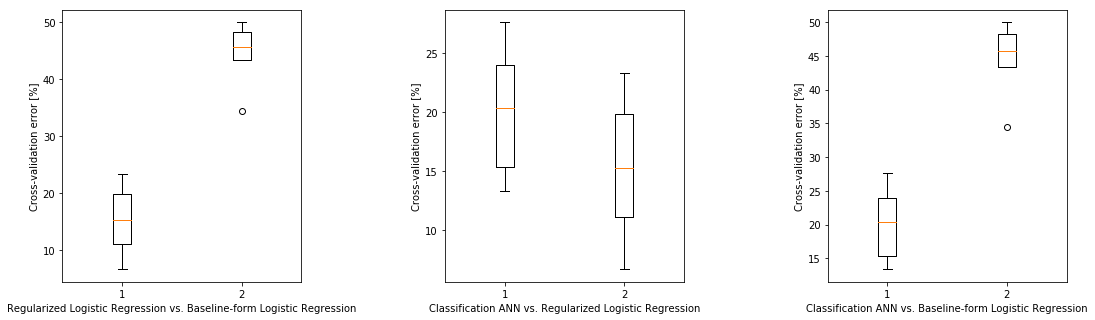

In [15]:
raw_data = df.get_values()

attr_col = list(df.columns).index('target')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col] # the 'target' column
attributeNames = list(df.columns[cols])
classLabels = raw_data[:, -1]
classNames = np.unique(classLabels)
N, M = X.shape
C = len(classNames)

K1 = 10 # for model selection
K2 = 10 # for optimal parameter selection

# K-fold crossvalidation
CV1 = model_selection.KFold(n_splits=K1, shuffle=True)

X = stats.zscore(X)

# Initialize variable
logreg_test_error_k1 = np.zeros(K1)
# tree_test_error_k1 = np.zeros(K1)
ann_test_error_k1 = np.zeros(K1)
baseline_test_error_k1 = np.zeros(K1)

k1=0
for par_index, test_index in CV1.split(X):
    print('Computing CV1 fold: {0}/{1}..'.format(k1+1,K1))
    print()
    
    # extract training and test set for current CV fold
    X_par, y_par = X[par_index,:], y[par_index]
    X_test, y_test = X[test_index,:], y[test_index]
    
    CV2 = model_selection.KFold(n_splits=K2, shuffle=False)
    
    #--------------------------------Regularized - LogRegression ----------------------------------------#
    lambda_interval = np.power(10.,range(-5,9))
    logreg_gen_error_rate_s = np.zeros(len(lambda_interval))
    
    for s in range(0, len(lambda_interval)):
        k2 = 0
        logreg_val_error_rate = np.zeros(K2)
        
        for train_index, val_index in CV2.split(X_par):

            # extract training and test set for current CV fold
            X_train, y_train = X_par[train_index,:], y_par[train_index]
            X_val, y_val = X_par[val_index,:], y_par[val_index]
        
            logreg_model = LogisticRegression(penalty='l2', C=1/lambda_interval[s], solver = 'lbfgs')
            logreg_model = logreg_model.fit(X_train, y_train)

            logreg_y_val_estimated = logreg_model.predict(X_val).T
            logreg_val_error_rate[k2] = np.sum(logreg_y_val_estimated != y_val) / len(y_val)
            k2 = k2 + 1
        
        logreg_gen_error_rate_s[s] = np.sum(logreg_val_error_rate) / len(logreg_val_error_rate)
            
    logreg_min_error = np.min(logreg_gen_error_rate_s)
    opt_lambda_index = np.argmin(logreg_gen_error_rate_s)
    opt_lambda = lambda_interval[opt_lambda_index]
    
    logreg_model = LogisticRegression(penalty='l2', C=1/lambda_interval[opt_lambda_index], solver = 'lbfgs')
    logreg_model = logreg_model.fit(X_par, y_par)
    
    logreg_y_test_estimated = logreg_model.predict(X_test).T
    logreg_test_error_k1[k1] = np.sum(logreg_y_test_estimated != y_test) / len(y_test)
    
    print('Error rate - regularized log-reg - CV1 fold {0}/{1}: {2}%'.format(k1+1, K1, np.round(100 * logreg_test_error_k1[k1], decimals = 2)))
    print('Optimal lambda: {0}'.format(opt_lambda))
#     print()
    #----------------------------------------------------------------------------------------------------#
    
    #--------------------------------Depth-controlled decision tree--------------------------------------#
#     # Tree complexity parameter - constraint on maximum depth
#     depth = np.arange(2, 16, 1)
#     tree_gen_error_rate_s = np.zeros(len(depth))
    
#     for s in range(0, len(depth)):
#         k2 = 0
#         tree_val_error_rate = np.zeros(K2)
        
#         for train_index, val_index in CV2.split(X_par):

#             # extract training and test set for current CV fold
#             X_train, y_train = X_par[train_index,:], y_par[train_index]
#             X_val, y_val = X_par[val_index,:], y_par[val_index]
        
#             tree_model = tree.DecisionTreeClassifier(criterion='gini', max_depth = depth[s])
#             tree_model = tree_model.fit(X_train, y_train)
    
#             tree_y_val_estimated = tree_model.predict(X_val).T
#             tree_val_error_rate[k2] = np.sum(tree_y_val_estimated != y_val) / len(y_val)
#             k2 = k2 + 1
        
#         tree_gen_error_rate_s[s] = np.sum(tree_val_error_rate) / len(tree_val_error_rate)
        
#     tree_min_error = np.min(tree_gen_error_rate_s)
#     opt_depth_index = np.argmin(tree_gen_error_rate_s)
#     opt_depth = depth[opt_depth_index]
    
#     tree_model = tree.DecisionTreeClassifier(criterion='gini', max_depth = depth[opt_depth_index])
#     tree_model = tree_model.fit(X_par, y_par)
    
#     tree_y_test_estimated = tree_model.predict(X_test).T
#     tree_test_error_k1[k1] = np.sum(tree_y_test_estimated != y_test) / len(y_test)
    
# #     plt.plot(depth, tree_gen_error_rate_s*100, color = sb.color_palette()[1])
# #     plt.xlabel('Model complexity (max tree depth)')
# #     plt.xticks(depth)
# #     plt.ylabel('Validation error (%)')
# #     plt.legend(['Generalization error from validation data'])
# #     plt.show()
    
#     print('Error rate - depth-controlled classification tree - CV1 fold {0}/{1}: {2}%'.format(k1+1, K1, np.round(100 * tree_test_error_k1[k1], decimals = 2)))
#     print('Optimal depth: {0}'.format(opt_depth))
# #     print()

    #----------------------------------------------------------------------------------------------------#
    
    #-----------------------------------------Classification ANN-----------------------------------------#
    h_unit_interval = np.arange(1, 6, 1) # number of hidden units in the single hidden layer
    nr_of_nn_replicates = 3 # when finding loss, take the best neural network from n replicates (to deal with local minima issues)
    max_iter = 10000 # max nr. of epochs (if convergence is not yet reached)
    
    ann_gen_error_rate_s = np.zeros(len(h_unit_interval))
    
    for s in range(0, len(h_unit_interval)):
        k2 = 0
        ann_val_error_rate = np.zeros(K2)
        
        for train_index, val_index in CV2.split(X_par):
            
            # extract training and test set for current CV fold
            X_train = torch.tensor(X_par[train_index,:], dtype=torch.float)
            y_train = torch.tensor(y_par[train_index], dtype=torch.float)
            
            X_val = torch.tensor(X_par[val_index,:], dtype=torch.float)
            y_val = torch.tensor(y_par[val_index], dtype=torch.float)
            
            ann_model = lambda: torch.nn.Sequential(
                                    torch.nn.Linear(M, h_unit_interval[s]),
                                    torch.nn.Tanh(),   
                                    torch.nn.Linear(h_unit_interval[s], 1), # H hidden units to 1 output neuron
                                    torch.nn.Sigmoid() # final tranfer function
                                )
            loss_fn = torch.nn.BCELoss() # Binary classification loss
            best_trained_neural_net, final_loss, learning_curve = train_neural_net(ann_model, loss_fn, X = X_train, y = y_train, n_replicates = nr_of_nn_replicates, max_iter = max_iter)

            ann_y_val_estimated = (best_trained_neural_net(X_val) > 0.5)
            # Convert tensors to numpy arrays, to work smoothly with class comparisons
            ann_y_val_estimated = ann_y_val_estimated.numpy().reshape(len(ann_y_val_estimated))
            y_val = y_val.numpy().reshape(len(y_val))
            
            ann_val_error_rate[k2] = np.sum(ann_y_val_estimated != y_val) / len(y_val)
            k2 = k2 + 1
            
        ann_gen_error_rate_s[s] = np.sum(ann_val_error_rate) / len(ann_val_error_rate)
            
    ann_min_error = np.min(ann_gen_error_rate_s)
    opt_nr_h_units_index = np.argmin(ann_gen_error_rate_s)
    opt_nr_h_units = h_unit_interval[opt_nr_h_units_index]

    tensor_X_par = torch.tensor(X_par, dtype=torch.float)
    tensor_y_par = torch.tensor(y_par, dtype=torch.float)
    tensor_X_test = torch.tensor(X_test, dtype=torch.float)

    ann_model = lambda: torch.nn.Sequential(
                                torch.nn.Linear(M, h_unit_interval[opt_nr_h_units_index]),
                                torch.nn.Tanh(),   
                                torch.nn.Linear(h_unit_interval[opt_nr_h_units_index], 1), # H hidden units to 1 output neuron
                                torch.nn.Sigmoid() # final tranfer function
                            )
    loss_fn = torch.nn.BCELoss() # Binary classification loss
    best_trained_neural_net, final_loss, learning_curve = train_neural_net(ann_model, loss_fn, X = tensor_X_par, y = tensor_y_par, n_replicates = nr_of_nn_replicates, max_iter = max_iter)

    ann_y_test_estimated = (best_trained_neural_net(tensor_X_test) > 0.5)
    # Convert tensors to numpy arrays, to work smoothly with class comparisons
    ann_y_test_estimated = ann_y_test_estimated.numpy().reshape(len(ann_y_test_estimated))
    ann_test_error_k1[k1] = np.sum(ann_y_test_estimated != y_test) / len(y_test)

    print('Error rate - Classification ANN - CV1 fold {0}/{1}: {2}%'.format(k1+1, K1, np.round(100 * ann_test_error_k1[k1], decimals = 2)))
    print('Optimal number of hidden units: {0}'.format(opt_nr_h_units))

    #----------------------------------------------------------------------------------------------------#
    
    #--------------------------------Baseline - LogRegression -------------------------------------------#
    class_1_count = y_par.sum() # class 1
    class_0_count = len(y_par) - y_par.sum() # class 0
    baseline_class = float(np.argmax([class_0_count, class_1_count]))

    baseline_test_error_k1[k1] = np.sum(y_test != baseline_class) / len(y_test)
    
    print('Error rate - baseline log-reg - CV1 fold {0}/{1}: {2}%'.format(k1+1, K1, np.round(100 * baseline_test_error_k1[k1], decimals = 2)))
#     print()
    #----------------------------------------------------------------------------------------------------#
    
    k1 = k1 + 1
    print()
    print()
    
#-----------------------------------Statistical evaluation of models------------------------------------------------#
# plt.figure(figsize = [18, 10])
plt.figure(figsize = [18, 5])
plt.subplots_adjust(wspace = 0.6)

# z = (logreg_test_error_k1 - tree_test_error_k1)
# z_mean = z.mean()
# deg_f = K1-1
# sig =  (z - z_mean).std() / np.sqrt(deg_f)
# alpha = 0.05

# zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
# zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

# plt.subplot(2, 3, 1)
# plt.boxplot(np.concatenate((logreg_test_error_k1.reshape((len(logreg_test_error_k1), 1))*100, tree_test_error_k1.reshape((len(tree_test_error_k1), 1))*100), axis = 1))
# plt.xlabel('Regularized Logistic Regression vs. Depth-controlled Classification Tree')
# plt.ylabel('Cross-validation error [%]')

# print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
# if zL <= 0 and zH >= 0 :
#     print('Regularized log-reg and depth-controlled classification tree classifiers are NOT significantly different')
# else:
#     print('Regularized log-reg and depth-controlled classification tree classifiers are significantly different')
# print()
# print()


# z = (tree_test_error_k1 - baseline_test_error_k1)
# z_mean = z.mean()
# deg_f = K1-1
# sig =  (z - z_mean).std() / np.sqrt(deg_f)
# alpha = 0.05

# zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
# zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

# plt.subplot(2, 3, 2)
# plt.boxplot(np.concatenate((tree_test_error_k1.reshape((len(tree_test_error_k1), 1))*100, baseline_test_error_k1.reshape((len(baseline_test_error_k1), 1))*100), axis = 1))
# plt.xlabel('Depth-controlled Classification Tree vs. Baseline-form Logistic Regression')
# plt.ylabel('Cross-validation error [%]')

# print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
# if zL <= 0 and zH >= 0 :
#     print('Depth-controlled classification tree and baseline log-reg classifiers are NOT significantly different')        
# else:
#     print('Depth-controlled classification tree and baseline log-reg classifiers are significantly different.')
# print()
# print()


z = (logreg_test_error_k1 - baseline_test_error_k1)
z_mean = z.mean()
deg_f = K1-1
sig =  (z - z_mean).std() / np.sqrt(deg_f)
alpha = 0.05

zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

plt.subplot(1, 3, 1)
plt.boxplot(np.concatenate((logreg_test_error_k1.reshape((len(logreg_test_error_k1), 1))*100, baseline_test_error_k1.reshape((len(baseline_test_error_k1), 1))*100), axis = 1))
plt.xlabel('Regularized Logistic Regression vs. Baseline-form Logistic Regression')
plt.ylabel('Cross-validation error [%]')

print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
if zL <= 0 and zH >= 0 :
    print('Regularized log-reg and baseline log-reg classifiers are NOT significantly different')        
else:
    print('Regularized log-reg and baseline log-reg classifiers are significantly different.')
print()
print()


# z = (ann_test_error_k1 - tree_test_error_k1)
# z_mean = z.mean()
# deg_f = K1-1
# sig =  (z - z_mean).std() / np.sqrt(deg_f)
# alpha = 0.05

# zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
# zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

# plt.subplot(2, 3, 4)
# plt.boxplot(np.concatenate((ann_test_error_k1.reshape((len(ann_test_error_k1), 1))*100, tree_test_error_k1.reshape((len(tree_test_error_k1), 1))*100), axis = 1))
# plt.xlabel('Classification ANN vs. Depth-controlled Classification Tree')
# plt.ylabel('Cross-validation error [%]')

# print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
# if zL <= 0 and zH >= 0 :
#     print('Classification ANN and depth-controlled classification tree classifiers are NOT significantly different')
# else:
#     print('Classification ANN and depth-controlled classification tree classifiers are significantly different')
# print()
# print()


z = (ann_test_error_k1 - logreg_test_error_k1)
z_mean = z.mean()
deg_f = K1-1
sig =  (z - z_mean).std() / np.sqrt(deg_f)
alpha = 0.05

zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

plt.subplot(1, 3, 2)
plt.boxplot(np.concatenate((ann_test_error_k1.reshape((len(ann_test_error_k1), 1))*100, logreg_test_error_k1.reshape((len(logreg_test_error_k1), 1))*100), axis = 1))
plt.xlabel('Classification ANN vs. Regularized Logistic Regression')
plt.ylabel('Cross-validation error [%]')

print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
if zL <= 0 and zH >= 0 :
    print('Classification ANN and regularized log-reg are NOT significantly different')        
else:
    print('Classification ANN and regularized log-reg are significantly different.')
print()
print()


z = (ann_test_error_k1 - baseline_test_error_k1)
z_mean = z.mean()
deg_f = K1-1
sig =  (z - z_mean).std() / np.sqrt(deg_f)
alpha = 0.05

zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

# plt.subplot(2, 3, 6)
plt.subplot(1, 3, 3)
plt.boxplot(np.concatenate((ann_test_error_k1.reshape((len(ann_test_error_k1), 1))*100, baseline_test_error_k1.reshape((len(baseline_test_error_k1), 1))*100), axis = 1))
plt.xlabel('Classification ANN vs. Baseline-form Logistic Regression')
plt.ylabel('Cross-validation error [%]')

print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
if zL <= 0 and zH >= 0 :
    print('Classification ANN and baseline log-reg classifiers are NOT significantly different')        
else:
    print('Classification ANN and baseline log-reg classifiers are significantly different.')
print()
print()
#-------------------------------------------------------------------------------------------------------------------#

gen_error_regularized_logreg = np.sum(logreg_test_error_k1) / len(logreg_test_error_k1)
# gen_error_tree = np.sum(tree_test_error_k1) / len(tree_test_error_k1)
gen_error_ann = np.sum(ann_test_error_k1) / len(ann_test_error_k1)
gen_error_baseline_logreg = np.sum(baseline_test_error_k1) / len(baseline_test_error_k1)

print('Generalized error rate - regularized log-reg: {0}%'.format(np.round(100 * gen_error_regularized_logreg, decimals = 2)))
# print('Generalized error rate - depth-controlled classification tree: {0}%'.format(np.round(100 * gen_error_tree, decimals = 2)))
print('Generalized error rate - classification ANN: {0}%'.format(np.round(100 * gen_error_ann, decimals = 2)))
print('Generalized error rate - baseline log-reg: {0}%'.format(np.round(100 * gen_error_baseline_logreg, decimals = 2)))

The results show that both the classification ANN and the regularized logistic regression give very good results, heavily lowering the generalization error below the baseline level results. We notice that the best results for ANN were computed using less than the maximum number of hidden units (5), suggesting that our ANN is not overly complex for this task. Also, the regularization strength λ chosen was in all ‘winning’ cases selected as the value 10, thus suggesting that some overfitting is present in our un-regularized model, however this is dealt with. We have correctly determined that all baseline model errors rest below the 50% threshold (which is to be expected, since if we randomly predict the more common class on a dataset containing two classes, the highest error case of this function is when both classes are having same number of elements, thus a baseline would give a maximum error of 50%.

Based on Fig. 6, it is clear that both regularized logistic regression and the classification ANN perform remarkably at this simple dataset classification task, and neither of them are statistically significantly better than the other, after overfitting has been minimized through the use of complexity-controlling parameters. Since properly training the ANN used up several hours, while the logistic regression was trained in less than 1 second, we can argue that, for our dataset, fitting an ANN would be unnecessary and resource-consuming.

#### Classification - 5

In [42]:
raw_data = df.get_values()

attr_col = list(df.columns).index('target')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col] # the 'target' column
attributeNames = list(df.columns[cols])
classLabels = raw_data[:, -1]
classNames = np.unique(classLabels)
N, M = X.shape
C = len(classNames)

X = stats.zscore(X)

log_model_with_reg = LogisticRegression(penalty='l2', C = 1/10.0, solver = 'lbfgs', fit_intercept = True) # remember to select the most-commonly found optimal lambda value
log_model_no_reg = LogisticRegression(solver = 'lbfgs', fit_intercept = True)

log_model_with_reg = log_model_with_reg.fit(X, y)
log_model_no_reg = log_model_no_reg.fit(X, y)

print('Weights for LogReg model with regularization:')
print('{:>20} {:>20}'.format('Intercept', str(np.round(log_model_with_reg.intercept_[0],3))))
for m in range(M):
    print('{:>20} {:>20}'.format(attributeNames[m], str(np.round(log_model_with_reg.coef_[0][m],3))))
    
print()
print()

print('Weights for LogReg model without regularization:')
print('{:>20} {:>20}'.format('Intercept', str(np.round(log_model_no_reg.intercept_[0],3))))
for m in range(M):
    print('{:>20} {:>20}'.format(attributeNames[m], str(np.round(log_model_no_reg.coef_[0][m],3))))

Weights for LogReg model with regularization:
           Intercept                0.188
                 age                0.017
            trestbps               -0.214
                chol               -0.118
             thalach                0.308
             oldpeak               -0.348
            sex_male               -0.475
         cp_atypical               -0.066
      cp_non_anginal                0.167
     cp_asymptomatic               -0.537
            fbs_true                0.091
        restecg_st_t                0.153
 restecg_hypertrophy               -0.045
           exang_yes               -0.284
          slope_flat               -0.228
   slope_downsloping                0.215
                ca_1               -0.564
                ca_2               -0.594
                ca_3                -0.35
          thal_fixed               -0.035
     thal_reversible               -0.563


Weights for LogReg model without regularization:
           Intercept 

Training our classification model upon a regularized logistic regression with optimal lambda found above as: λ = 10, we obtain the following linear equation (which would then be fed into the sigmoid function to output our final probability result):

$y ̌ = \sigma(0.18 + 0.01x_{age} -0.21x_{trestbps} - 0.11x_{chol} + 0.31x_{thalach} - 0.34x_{oldpeak} - 0.47x_{sex-male} - 0.06x_{cp-atypical} + 0.16x_{cp-nonanginal} - 0.53x_{cp-asymptomatic} + 0.09x_{fbs-true} + 0.15x_{restecg-st-t} - 0.04x_{restecg-hypertrophy} - 0.28x_{exang-yes} - 0.22x_{slope-flat} + 0.21x_{slope-downsloping} - 0.56x_{ca-1} - 0.59x_{ca-2} - 0.35x_{ca-3} - 0.03x_{thal-fixed} - 0.56x_{thal-reversible})$

We can notice that, since the data has been normalized and standardized prior to the model fitting, the weights will be computed and shown in the same order of magnitude. In this situation, it is correct to interpret that e.g. the value of ‘thalach’ is the strongest positively-affecting component of the equation (reasonable, since higher maximum recorded heart rate will probably positively correlate with increased chance for heart disease), or that the probability of male having heart disease is significantly lower than the probability of women (since xsex-male has negative coefficient). Compared with the weights found earlier for our chosen regression problem, we can notice that both the relevance and the magnitude of impact (and sign) upon the output has changed for most of our attributes.

### III. Analysis of findings - Discussion and Conclusion

From our analysis, we have determined that our classification task of predicting whether patients suffer or not of angiographic heart disease based on the collected dataset parameters can be solved and achieve a high accuracy level by machine learning methods such as logistic regression or classification ANNs. We have also learned to look at the resource trade-cost between training an extensive ANN for solving our problem, or selecting a more-simple but just-as-accurate model (e.g. logistic regression or perhaps Naïve-Bayes). Regarding the regression problem analysis, we argue that our model results will only be improved through new data collection, since the dataset and most of its attributes are very weakly correlated together.

Looking for comparison of our regression and classification results in the academic world, we have found several papers ([2,3]) discussing the training of Neural Networks with or without ensemble, upon this dataset to perform classification. The results are similar to what we achieved, e.g.: [2] achieved 18% classification error rate using an ensemble NN; while [3] achieved 18.7% error rate using MLP. We were unable to find papers treating either the results of logistic regression classifier (probably due to its simplicity) or results of any regressor models.

### IV. Bibliography

[1] Frese, A. and Sbirna, S. (2019), “UCL Heart Disease - Data: Feature extraction and visualization”.

[2] Brown, G. (2004), “Diversity in Neural Network Ensembles”, University of Birmingham.

[3] Duch, W., Grudzinski, K. and Diercksen, G.H. (1998). “Minimal distance neural networks”, IEEE International Joint Conference on Neural Networks Proceedings 1998, 2: 1299-1304.